In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
data_dir = 'C:\\Users\\kaizi\\Desktop\\jupyter\\DeepLearning\\Grapevine_Leaves_Image_Dataset'

In [5]:
os.listdir(data_dir)

['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']

In [6]:
img_path = data_dir+'\\Ak\\'

In [7]:
from PIL import Image

def count_images(folder_path):
    count = 0
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.png'):
            count += 1
    return count

def analyze_images(folder_path):
    images = []
    sizes = []
    mean_colors = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.png'):
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                # Get image size
                images.append(img)
                width, height = img.size
                sizes.append((width, height))
                
                # Convert image to numpy array
                img_array = np.array(img)
                
                # Calculate mean color
                mean_color = img_array.mean(axis=(0, 1))
                mean_colors.append(mean_color)

    return images, sizes, mean_colors

def plot_distribution(sizes, mean_colors):
    # Plot size distribution
    widths, heights = zip(*sizes)
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, alpha=0.7, label='Width')
    plt.hist(heights, bins=20, alpha=0.7, label='Height')
    plt.xlabel('Pixels')
    plt.ylabel('Frequency')
    plt.title('Image Size Distribution')
    plt.legend()

    # Plot color distribution
    mean_colors = np.array(mean_colors)
    plt.subplot(1, 2, 2)
    plt.hist(mean_colors[:, 0], bins=20, alpha=0.7, label='Red', color='red')
    plt.hist(mean_colors[:, 1], bins=20, alpha=0.7, label='Green', color='green')
    plt.hist(mean_colors[:, 2], bins=20, alpha=0.7, label='Blue', color='blue')
    plt.xlabel('Mean Color Value')
    plt.ylabel('Frequency')
    plt.title('Color Distribution')
    plt.legend()

    plt.tight_layout()
    plt.show()


Total number of images: 100


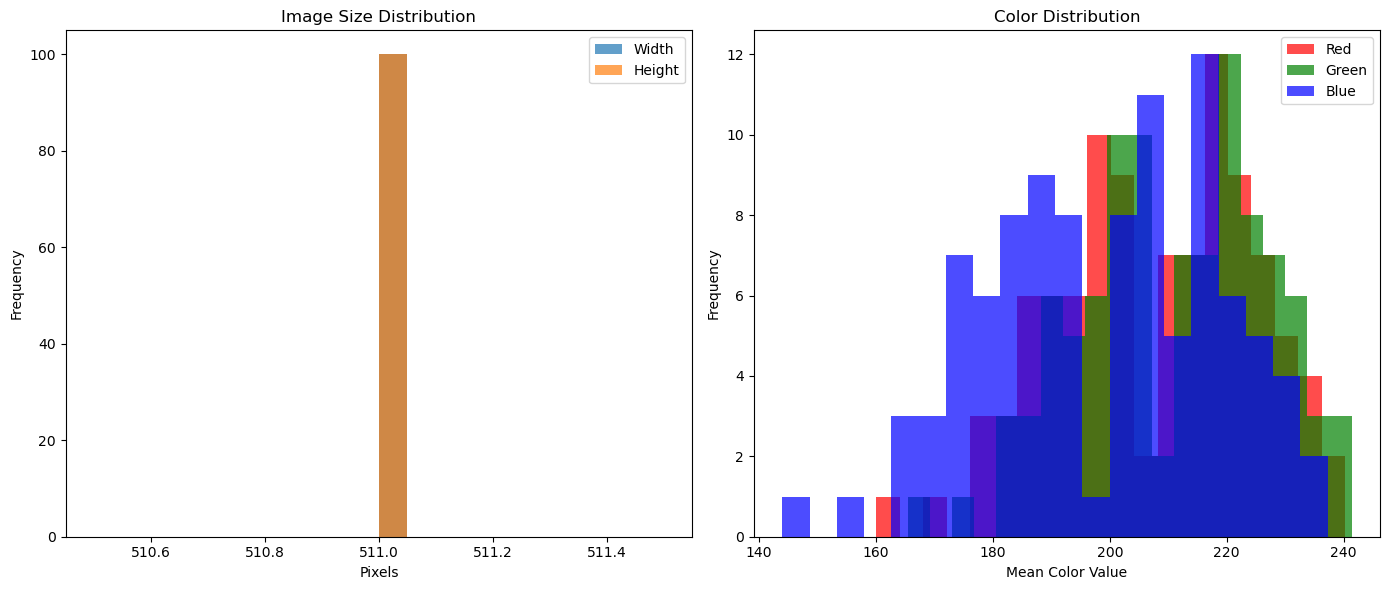

In [8]:
# Count the number of images
image_count = count_images(img_path)
print(f'Total number of images: {image_count}')

images, sizes, mean_colors = analyze_images(img_path)
plot_distribution(sizes, mean_colors)

In [9]:
# Image dimensions
rescale_height, rescale_width = 112, 112

In [10]:
import cv2
from PIL import Image

def load_and_preprocess_images(image_list, img_height=56, img_width=56):
    images = []

    def detect_object_and_adjust(image):
        # Convert to numpy array
        img_array = np.array(image)
        # Convert to grayscale if the image has more than one channel
        if len(img_array.shape) == 3:
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        
        # Detect object (using a simple threshold-based method for example purposes)
        _, thresh = cv2.threshold(img_array, 128, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) == 0:
            return image  # No object found, return original image
        
        # Find the largest contour which we'll assume is our object
        contour = max(contours, key=cv2.contourArea)
        
        # Get bounding rectangle for the largest contour
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        # Calculate the rotation angle to align the leaf
        angle = rect[2]
        if angle < -45:
            angle += 90
        
        # Rotate the original image to standard orientation
        rotated_img = cv2.warpAffine(img_array, cv2.getRotationMatrix2D(rect[0], angle, 1.0), (img_array.shape[1], img_array.shape[0]), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        
        # Find bounding box coordinates after rotation
        x, y, w, h = cv2.boundingRect(contour)
        
        # Expand the bounding box by 10 pixels on each side
        x_min = max(x - 10, 0)
        y_min = max(y - 10, 0)
        x_max = min(x + w + 10, rotated_img.shape[1])
        y_max = min(y + h + 10, rotated_img.shape[0])
        
        # Crop the image to the expanded bounding box
        cropped_img = rotated_img[y_min:y_max, x_min:x_max]
        
        # Resize the cropped image to the target dimensions
        resized_img = cv2.resize(cropped_img, (img_width, img_height), interpolation=cv2.INTER_CUBIC)
        
        return Image.fromarray(resized_img)

    for image in image_list:
        # Detect and adjust object
        img = detect_object_and_adjust(image)
        # Convert to numpy array
        img_array = np.array(img)
        # Normalize the images to the range [-1, 1]
        img_array = (img_array - 127.5) / 127.5
        images.append(img_array)

    images = np.expand_dims(np.array(images), axis=-1)  # Expand dimensions to add channel for grayscale

    # Convert to TensorFlow tensor
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)

    return images_tensor.numpy()

In [11]:
# Load and preprocess images
post_images = load_and_preprocess_images(images, rescale_height, rescale_width)

C:\Users\kaizi\AppData\Local\Temp\ipykernel_19036\995404242.py:27: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


In [12]:
type(post_images[0])

numpy.ndarray

In [13]:
post_images.shape

(100, 112, 112, 1)

In [14]:
def plot_ori_images(images, num_images=20, title="Title"):
    num_rows = (num_images // 7) + 1  # Calculate number of rows needed
    plt.figure(figsize=(14, 2 * num_rows))  # Adjust figure size based on number of rows
    
    for i in range(min(num_images, len(images))):
        ax = plt.subplot(num_rows, 7, i + 1)  # Adjust subplot position for multiple rows and 7 columns
        plt.imshow(images[i], cmap='gray')  # Display the image (assuming it's grayscale)
        plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [15]:
def plot_post_images(images, num_images=20, title="Title"):
    num_rows = (num_images // 7) + 1  # Calculate number of rows needed
    plt.figure(figsize=(14, 2 * num_rows))  # Adjust figure size based on number of rows
    
    for i in range(num_images):
        ax = plt.subplot(num_rows, 7, i + 1)  # Adjust subplot position for multiple rows and 7 columns
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

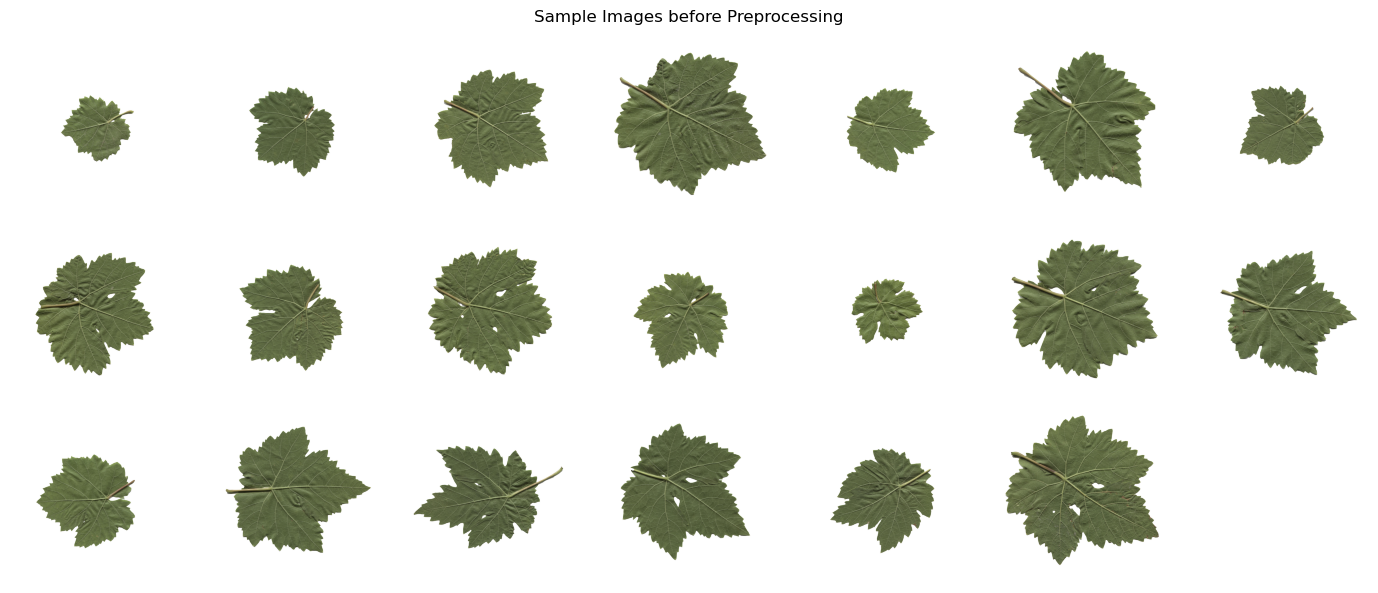

In [16]:
plot_ori_images(images, title="Sample Images before Preprocessing")

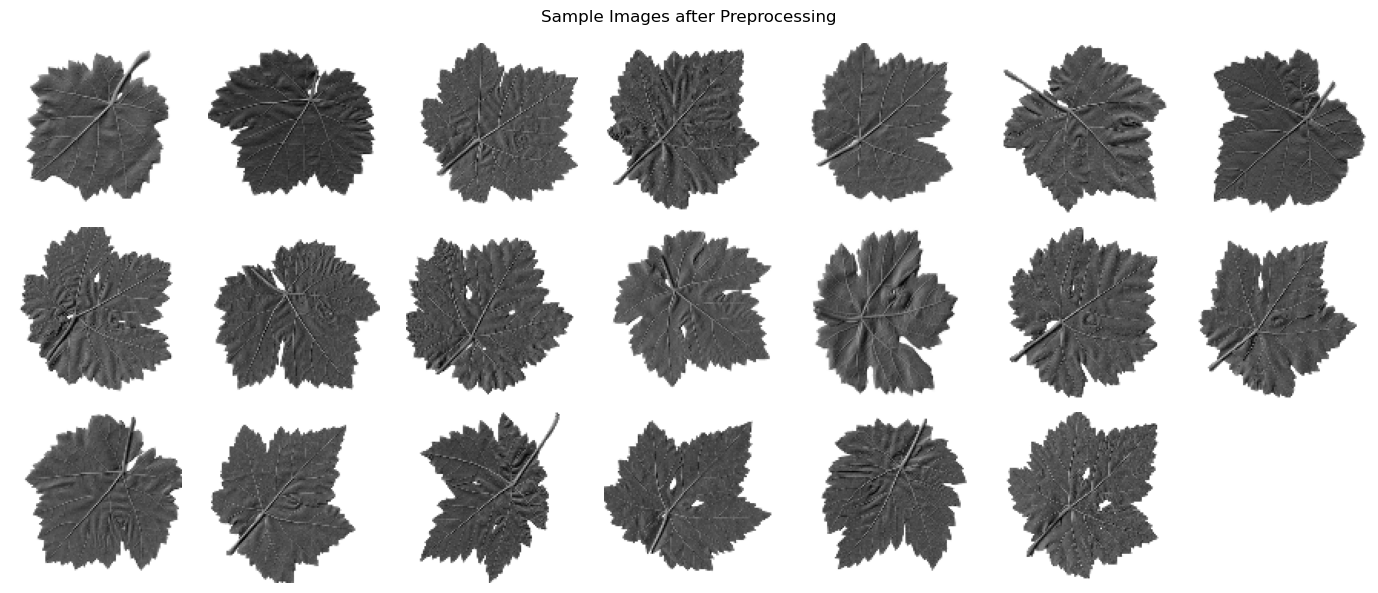

In [17]:
plot_post_images(post_images, title="Sample Images after Preprocessing")

## Generator and Discriminator

In [27]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D, UpSampling2D, Conv2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import glob

In [19]:
np.random.seed(42)
tf.random.set_seed(42)

In [20]:
def build_discriminator(img_shape):
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1))

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)


In [21]:
def build_generator(latent_dim, img_shape):
    model = Sequential()
    
    model.add(Dense(128 * 28 * 28, activation="relu", input_dim=latent_dim))
    model.add(Reshape((28, 28, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)


In [22]:
class WGAN_GP:
    def __init__(self, img_shape, latent_dim, n_critic=5, lr=0.0002, beta1=0.5, beta2=0.9):
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.n_critic = n_critic
        self.optimizer = Adam(learning_rate=lr, beta_1=beta1, beta_2=beta2)
        
        # Build and compile the discriminator
        self.discriminator = build_discriminator(img_shape)
        self.discriminator.compile(loss=self.wasserstein_loss, optimizer=self.optimizer)

        # Build the generator
        self.generator = build_generator(latent_dim, img_shape)
        
        # Generator takes noise as input and generates images
        z = Input(shape=(latent_dim,))
        img = self.generator(z)
        
        # Only train the generator for the combined model
        self.discriminator.trainable = False
        
        # Discriminator determines validity of the generated images
        valid = self.discriminator(img)
        
        # Combined model (stacked generator and discriminator)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss, optimizer=self.optimizer)

    def wasserstein_loss(self, y_true, y_pred):
        return tf.reduce_mean(y_true * y_pred)

    def gradient_penalty(self, batch_size, real_images, fake_images):
        epsilon = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolated = epsilon * real_images + (1 - epsilon) * fake_images

        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            validity_interpolated = self.discriminator(interpolated)

        gradients = tape.gradient(validity_interpolated, [interpolated])[0]
        gradients_l2_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean((gradients_l2_norm - 1.0) ** 2)
        
        return gradient_penalty

    def train(self, data, batch_size, epochs, sample_interval=50):
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):
            for _ in range(self.n_critic):
                idx = np.random.randint(0, data.shape[0], batch_size)
                real_images = data[idx]

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                fake_images = self.generator.predict(noise)

                d_loss_real = self.discriminator.train_on_batch(real_images, valid)
                d_loss_fake = self.discriminator.train_on_batch(fake_images, fake)

                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real) + 10 * gp

            g_loss = self.combined.train_on_batch(noise, valid)

            if epoch % sample_interval == 0:
                print(f'{epoch} [D loss: {d_loss}] [G loss: {g_loss}]')
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_images = self.generator.predict(noise)

        gen_images = 0.5 * gen_images + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.show()
        fig.savefig(f'images_{epoch}.png')
        plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


C:\Users\kaizi\anaconda3\lib\site-packages\keras\src\backend\tensorflow\trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
0 [D loss: 9.397390365600586] [G loss: [array(0.02483431, dtype=float32), array(0.02483431, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


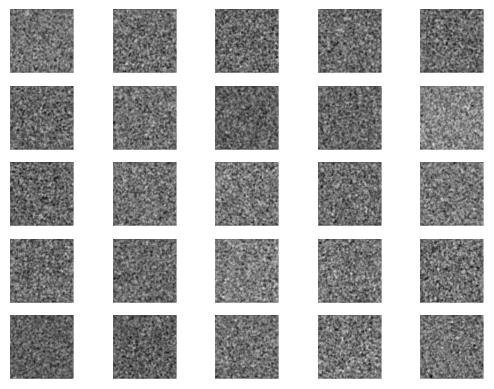

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Set parameters
latent_dim = 100
epochs = 5000
batch_size = 32
sample_interval = 500

IMG_WIDTH = 112
IMG_HEIGHT = 112
CHANNELS = 1
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)

# Initialize and train the WGAN-GP
wgan_gp = WGAN_GP(IMG_SHAPE, latent_dim)
wgan_gp.train(post_images, batch_size, epochs, sample_interval)